### Essential libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from imblearn.over_sampling import SMOTE

##Loading the data

In [1]:
file_path = '/content/diabetes.csv'
data = pd.read_csv(file_path)

# Exploring the data
print(data.head())


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


### correlation matrix and pairplot

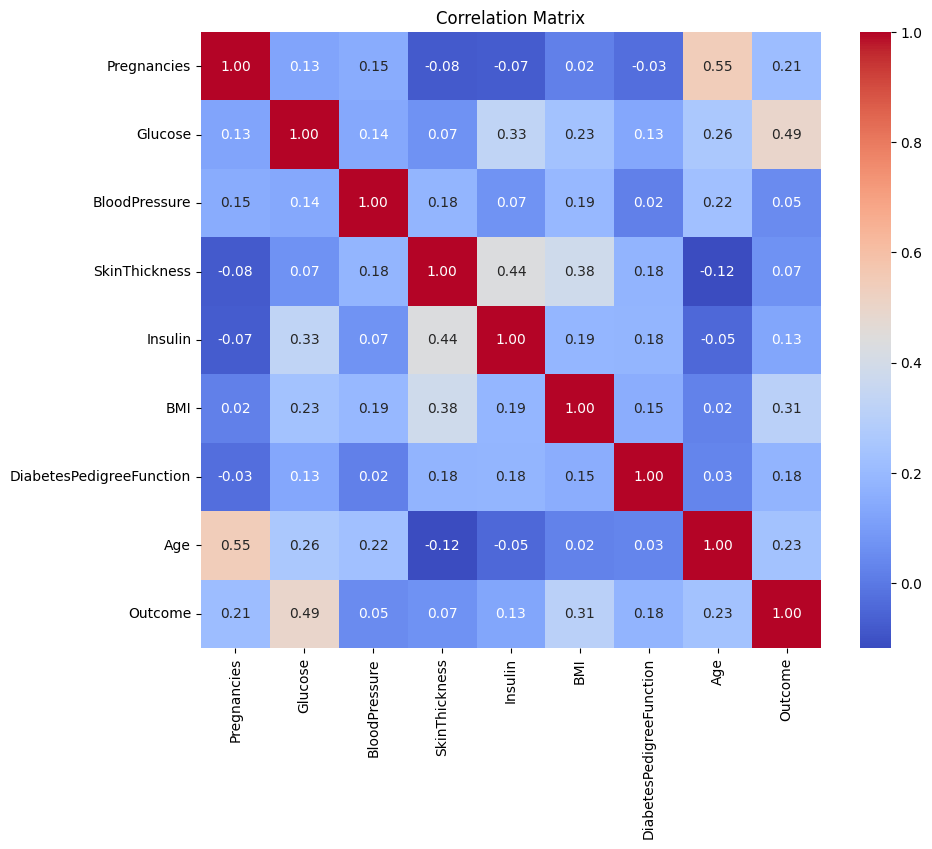

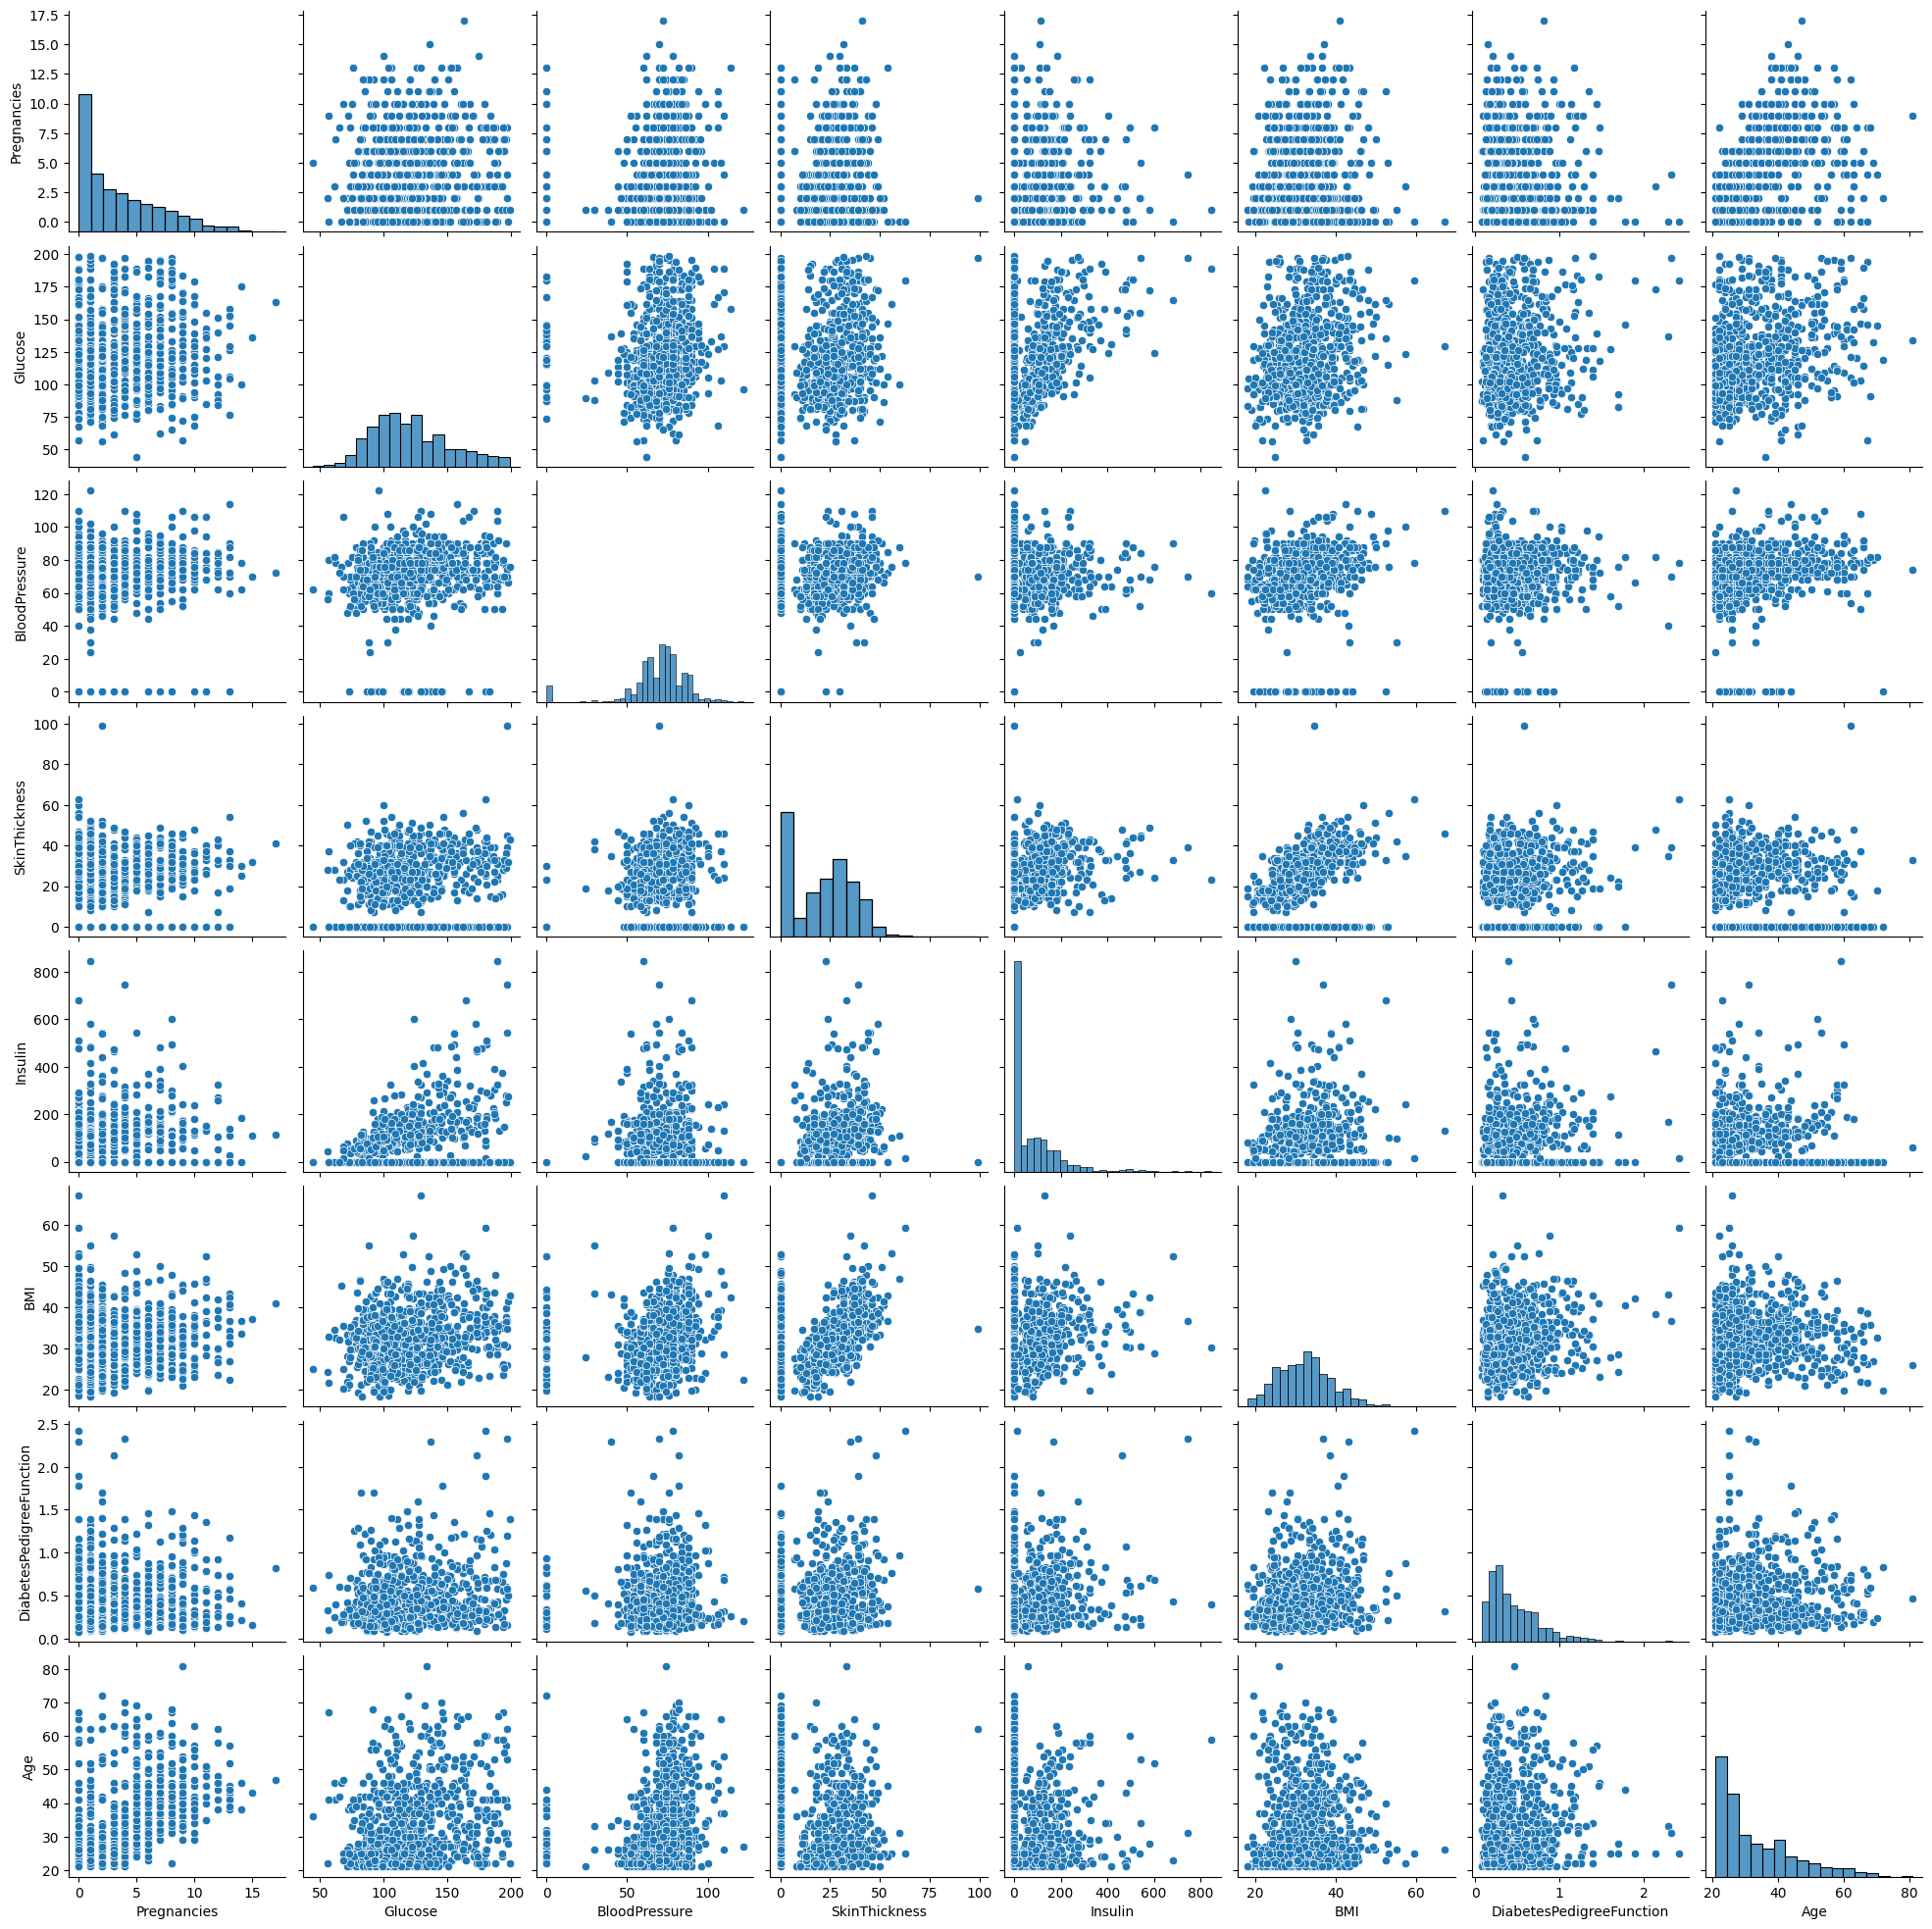

In [ ]:
correlation_matrix = data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Generate a pairplot for the dataset excluding the 'Outcome' column
sns.pairplot(data.drop('Outcome', axis=1))
plt.show()


### distribution plot

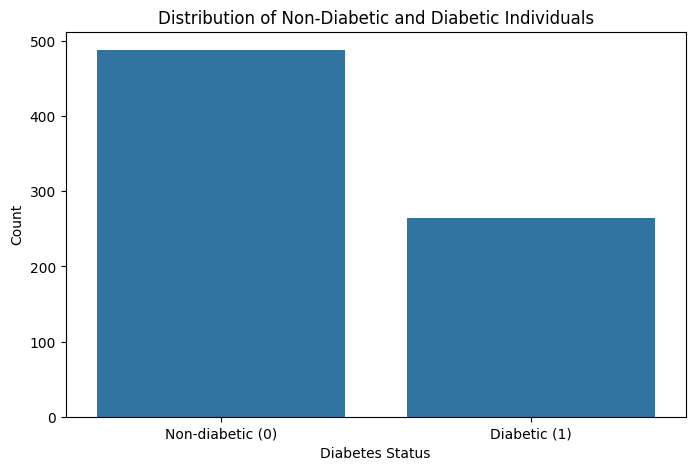

In [ ]:
# Create a distribution plot for people with and without diabetes
plt.figure(figsize=(8, 5))
sns.countplot(x='Outcome', data=data)
plt.title('Distribution of Non-Diabetic and Diabetic Individuals')
plt.xlabel('Diabetes Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-diabetic (0)', 'Diabetic (1)'])
plt.show()


### Box plot and histogram

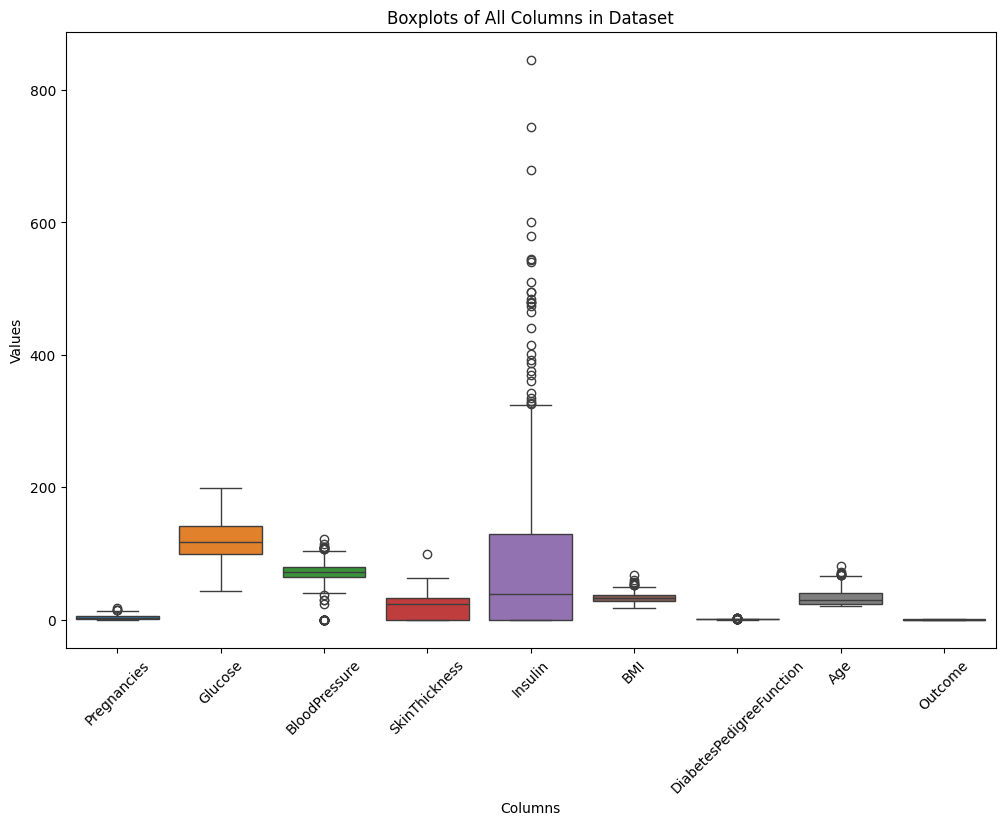

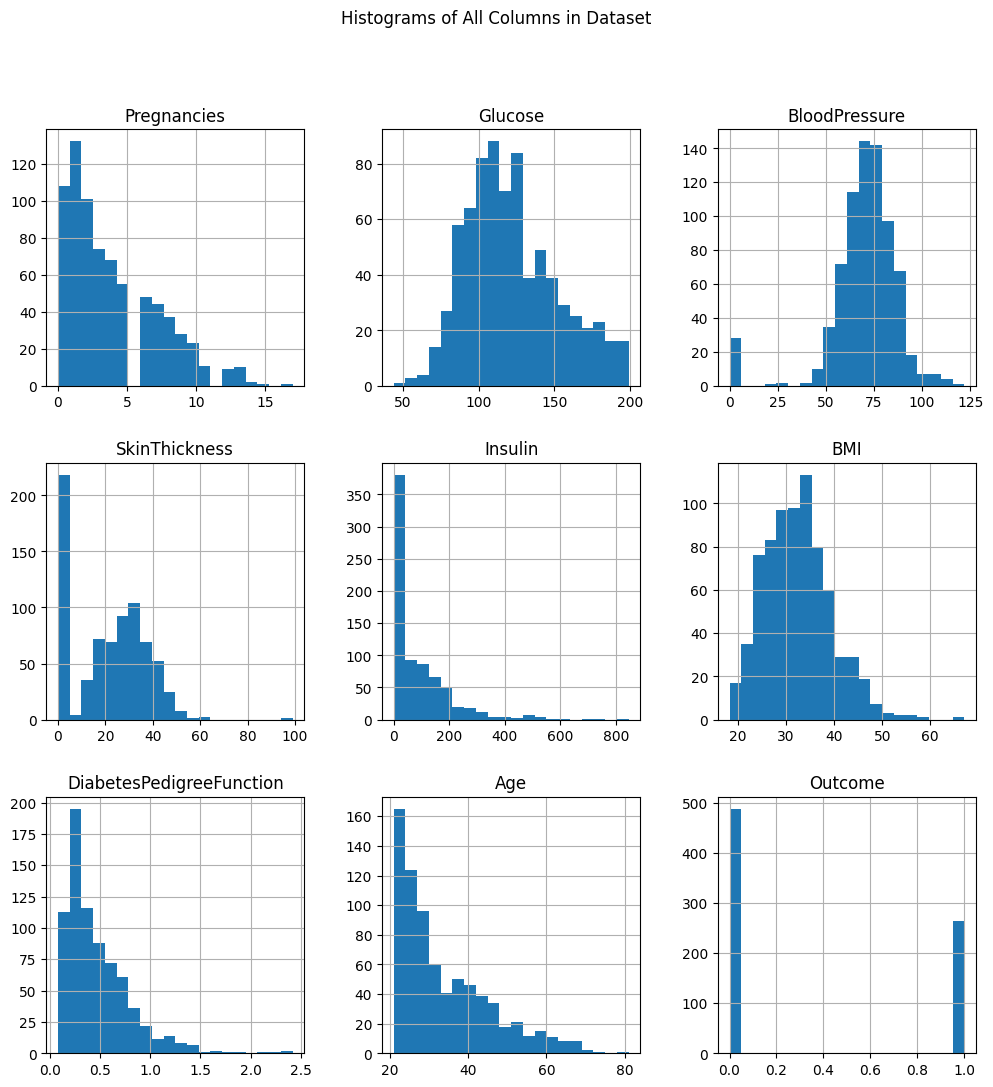

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=data)
plt.title('Boxplots of All Columns in Dataset')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

# Plot histograms for each column
data.hist(bins=20, figsize=(12, 12))
plt.suptitle('Histograms of All Columns in Dataset')
plt.show()


In [2]:
data = data[data['BMI'] != 0]
data = data[data['Glucose'] != 0]

In [4]:
# Separate features and labels
X = data.drop(columns=['Outcome'])
y = data['Outcome'].values

# Identify outliers using IQR and replace with median
def replace_outliers_with_median(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median_value = df[column].median()
    df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), median_value, df[column])

# Replace outliers in Insulin and SkinThickness columns
replace_outliers_with_median(X, 'Insulin')
replace_outliers_with_median(X, 'SkinThickness')

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Convert data to tensor
X_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_tensor = torch.tensor(y_resampled, dtype=torch.float32).view(-1, 1)

# Split the dataset into training, validation, and test sets
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### model

In [5]:
# Definition of the neural network model
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(8, 100)
        self.batch_norm1 = nn.BatchNorm1d(100)
        self.layer2 = nn.Linear(100, 50)
        self.dropout = nn.Dropout(0.2)
        self.layer3 = nn.Linear(50, 50)
        self.layer4 = nn.Linear(50, 20)
        self.layer5 = nn.Linear(20, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.batch_norm1(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.layer5(x)
        return x

# Creating the model, criterion, and optimizer
model = NeuralNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Training the model

Epoch 1/15, Train Loss: 0.6728, Train Acc: 0.5771, Val Loss: 0.6359, Val Acc: 0.7400
Epoch 2/15, Train Loss: 0.5684, Train Acc: 0.7586, Val Loss: 0.4682, Val Acc: 0.7600
Epoch 3/15, Train Loss: 0.4859, Train Acc: 0.7700, Val Loss: 0.4135, Val Acc: 0.7600
Epoch 4/15, Train Loss: 0.4753, Train Acc: 0.7843, Val Loss: 0.4153, Val Acc: 0.7900
Epoch 5/15, Train Loss: 0.4523, Train Acc: 0.7886, Val Loss: 0.3972, Val Acc: 0.8100
Epoch 6/15, Train Loss: 0.4422, Train Acc: 0.8043, Val Loss: 0.3868, Val Acc: 0.8100
Epoch 7/15, Train Loss: 0.4395, Train Acc: 0.8057, Val Loss: 0.3811, Val Acc: 0.8100
Epoch 8/15, Train Loss: 0.4264, Train Acc: 0.8157, Val Loss: 0.3827, Val Acc: 0.8100
Epoch 9/15, Train Loss: 0.4148, Train Acc: 0.8171, Val Loss: 0.3793, Val Acc: 0.8200
Epoch 10/15, Train Loss: 0.4203, Train Acc: 0.7971, Val Loss: 0.3922, Val Acc: 0.8200
Epoch 11/15, Train Loss: 0.3998, Train Acc: 0.8329, Val Loss: 0.3920, Val Acc: 0.8100
Epoch 12/15, Train Loss: 0.4005, Train Acc: 0.8314, Val Loss: 0

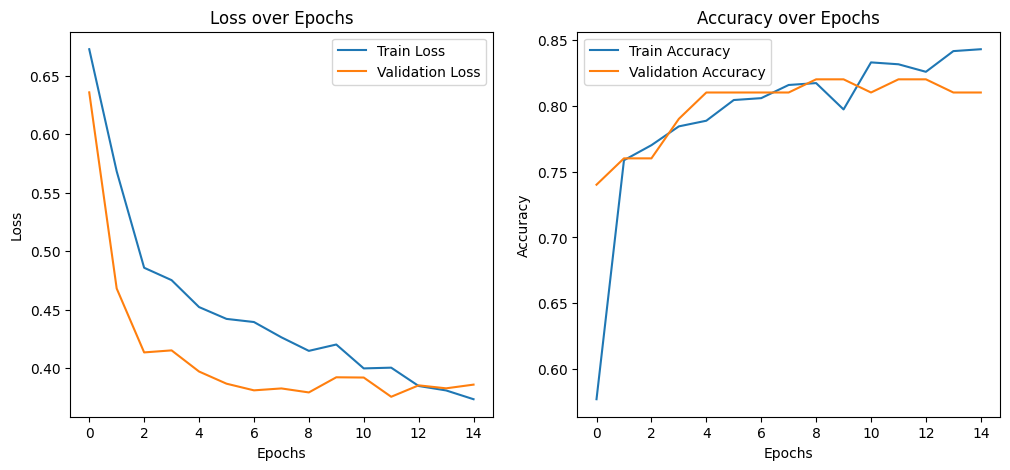

In [ ]:
# Function for training the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = torch.sigmoid(outputs).round()
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss /= len(train_loader)
        train_acc = correct_train / total_train
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = torch.sigmoid(outputs).round()
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = correct_val / total_val
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Training the model
num_epochs = 15
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()


### Evaluating the model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = torch.sigmoid(outputs).round()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    all_labels = torch.tensor(all_labels)
    all_predictions = torch.tensor(all_predictions)

    acc = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return acc, precision, recall, f1, conf_matrix

# Evaluating the model on test data
test_acc, test_precision, test_recall, test_f1, test_conf_matrix = evaluate_model(model, test_loader)

# Displaying the results
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print('Confusion Matrix:')
print(test_conf_matrix)


Test Accuracy: 0.8000
Test Precision: 0.7248
Test Recall: 0.8876
Test F1 Score: 0.7980
Confusion Matrix:
[[81 30]
 [10 79]]


<ipython-input-11-28b60638a880>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  all_labels = torch.tensor(all_labels)


In [ ]:
! pip install shap

### KernelExplainer method

Indices of the selected test samples: [163, 28, 6]


  0%|          | 0/3 [00:00<?, ?it/s]

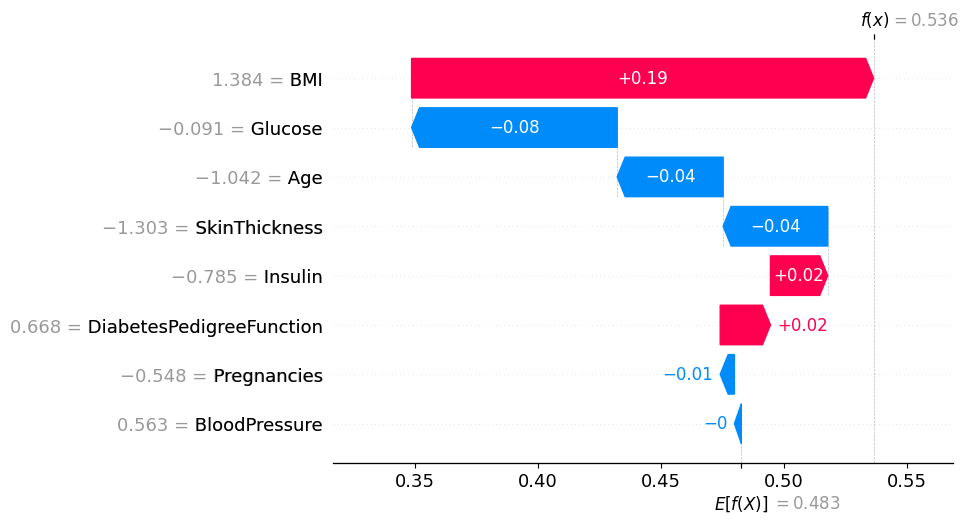

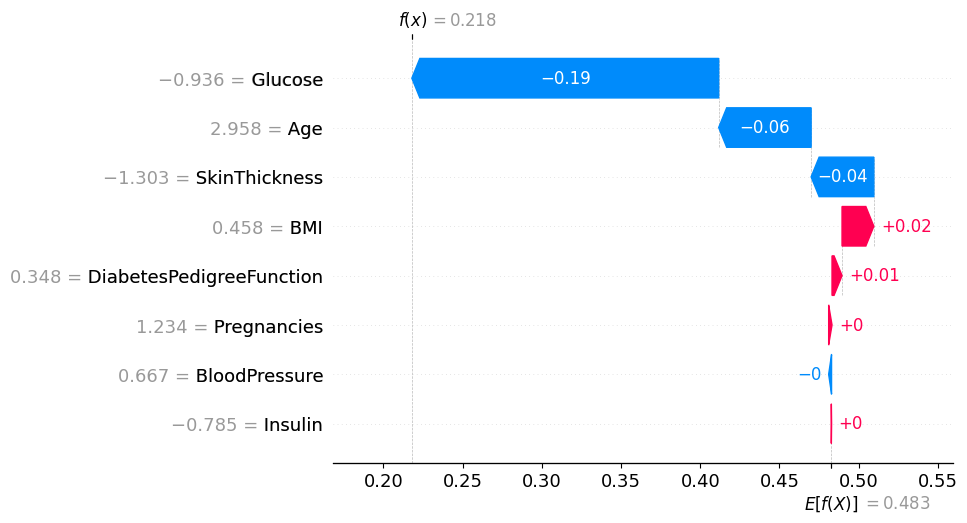

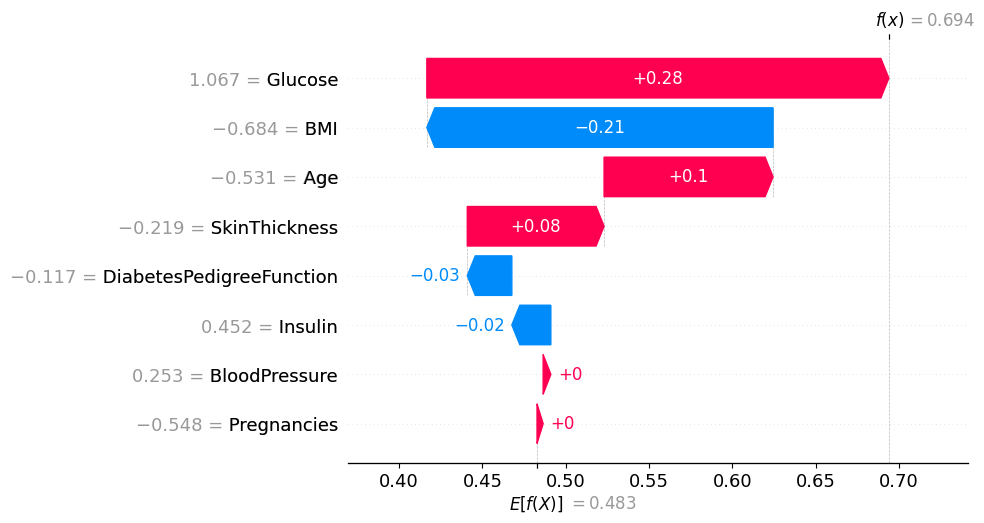

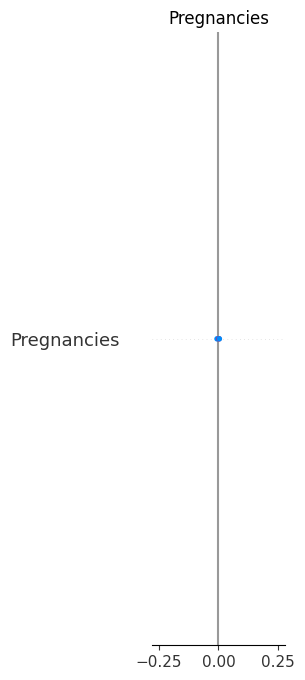

Test Labels: [[1.]
 [0.]
 [1.]]
Test Predictions: [[1.]
 [0.]
 [1.]]


In [ ]:
import shap
import random
import numpy as np
import torch

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Select three random samples from the test dataset
random_indices = random.sample(range(len(test_dataset)), 3)
test_samples = [test_dataset[i] for i in random_indices]

# Print the indices of the selected samples
print(f'Indices of the selected test samples: {random_indices}')

# Convert samples to appropriate format for Explainer
test_inputs = torch.stack([sample[0] for sample in test_samples]).numpy()
test_labels = torch.stack([sample[1] for sample in test_samples]).numpy()

# Define prediction function for the model
def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        return torch.sigmoid(outputs).cpu().numpy()

# Create an explainer using SHAP's KernelExplainer
explainer = shap.KernelExplainer(model_predict, test_inputs)

# Compute SHAP values for the selected samples
shap_values = explainer.shap_values(test_inputs)

# Plot SHAP values for each selected sample using waterfall plot
shap.initjs()
for i in range(len(test_samples)):
    shap.waterfall_plot(shap.Explanation(values=shap_values[i].reshape(-1),
                                         base_values=explainer.expected_value,
                                         data=test_inputs[i],
                                         feature_names=data.columns[:-1]))

# Use shap.summary_plot for an overview
shap.summary_plot(shap_values, test_inputs, feature_names=data.columns[:-1], plot_type="bar")

test_predictions = model_predict(test_inputs)
print(f'Test Labels: {test_labels}')
print(f'Test Predictions: {test_predictions.round()}')


In [ ]:
! pip install lime

### LimeTabularExplainer method

In [ ]:
import lime
import lime.lime_tabular
import numpy as np

# Print the indices of the selected samples
print(f'Indices of the selected test samples: {random_indices}')

# Convert samples to appropriate format for LIME
test_inputs = np.array([sample[0].numpy() for sample in test_samples])
test_labels = np.array([sample[1].numpy() for sample in test_samples])

# Define prediction function for the model
def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).cpu().numpy()
        return np.hstack((1 - probs, probs))  # Convert to 2D array with class probabilities

# Create a LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_scaled,
    feature_names=data.columns[:-1],
    class_names=['No Diabetes', 'Diabetes'],
    mode='classification'
)

lime_explanations = []
for i in range(len(test_samples)):
    exp = lime_explainer.explain_instance(test_inputs[i], model_predict, num_features=len(data.columns[:-1]))
    lime_explanations.append(exp)
    exp.show_in_notebook(show_table=True)
    print(exp.as_list())

# Display actual and predicted labels for the selected samples
test_predictions = model_predict(test_inputs)
predicted_labels = test_predictions[:, 1].round()  # Use the positive class predictions

print(f'Indices of the selected test samples: {random_indices}')
print(f'Test Labels: {test_labels}')
print(f'Test Predictions: {predicted_labels}')


Indices of the selected test samples: [163, 28, 6]


[('BMI > 0.58', 0.21902880802370023), ('DiabetesPedigreeFunction > 0.47', 0.18167028315010264), ('-0.12 < Glucose <= 0.61', 0.08904440042720846), ('Age <= -0.79', -0.07461664650631797), ('-0.84 < Pregnancies <= -0.25', -0.06541207502145722), ('BloodPressure > 0.56', 0.03709144403469578), ('-0.79 < Insulin <= -0.40', 0.02407863142324194), ('SkinThickness <= -1.30', -0.0023949928958703396)]


[('Glucose <= -0.69', -0.35046163864733715), ('Pregnancies > 0.64', 0.20169748411518418), ('0.00 < BMI <= 0.58', 0.053306480584884595), ('Age > 0.66', -0.022504572646383083), ('BloodPressure > 0.56', 0.015777835787037543), ('SkinThickness <= -1.30', 0.013459035410333232), ('-0.30 < DiabetesPedigreeFunction <= 0.47', -0.01227476564884544), ('-0.79 < Insulin <= -0.40', -0.009492809953272327)]


[('Glucose > 0.61', 0.4485141616013532), ('BMI <= -0.60', -0.22136553758104346), ('-0.84 < Pregnancies <= -0.25', -0.05033508308944913), ('-0.40 < Insulin <= 0.63', 0.02992060995310418), ('-1.30 < SkinThickness <= 0.16', -0.01683005719315432), ('0.15 < BloodPressure <= 0.56', 0.008405321880002451), ('-0.30 < DiabetesPedigreeFunction <= 0.47', -0.007807226534163993), ('-0.79 < Age <= -0.36', -0.00585001719258445)]
Indices of the selected test samples: [163, 28, 6]
Test Labels: [[1.]
 [0.]
 [1.]]
Test Predictions: [1. 0. 1.]


### lime analysis on all test data

In [ ]:
import lime
import lime.lime_tabular
import numpy as np
import torch

# Define prediction function for the model
def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).cpu().numpy()
        return np.hstack((1 - probs, probs))  # Convert to 2D array with class probabilities

# Convert test inputs to appropriate format for LIME
test_inputs = torch.stack([sample[0] for sample in test_dataset]).numpy()
test_labels = torch.stack([sample[1] for sample in test_dataset]).numpy()

# Create a LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_scaled,
    feature_names=data.columns[:-1],
    class_names=['No Diabetes', 'Diabetes'],
    mode='classification'
)

lime_explanations = []
for i in range(len(test_inputs)):
    exp = lime_explainer.explain_instance(test_inputs[i], model_predict, num_features=len(data.columns[:-1]))
    lime_explanations.append(exp)
    exp.show_in_notebook(show_table=True)
    print(exp.as_list())

# Display actual and predicted labels for the test set
test_predictions = model_predict(test_inputs)
predicted_labels = test_predictions[:, 1].round()  # Use the positive class predictions

print(f'Test Labels: {test_labels}')
print(f'Test Predictions: {predicted_labels}')


### Kernel Explained on all test data

In [ ]:
def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).cpu().numpy()
        return probs

# Convert test inputs to appropriate format for SHAP
test_inputs = torch.stack([sample[0] for sample in test_dataset]).numpy()

# Create an explainer using SHAP's KernelExplainer
explainer = shap.KernelExplainer(model_predict, test_inputs)

# Compute SHAP values for the entire test set
shap_values = explainer.shap_values(test_inputs)

# Plot SHAP summary plot for the entire test set
shap.summary_plot(shap_values, test_inputs, feature_names=data.columns[:-1])
for i in range(len(test_inputs)):
    shap.waterfall_plot(shap.Explanation(values=shap_values[i].reshape(-1),
                                         base_values=explainer.expected_value,
                                         data=test_inputs[i],
                                         feature_names=data.columns[:-1]))

shap.summary_plot(shap_values, test_inputs, feature_names=data.columns[:-1], plot_type="bar")